In [1]:
from pygmo import hypervolume
import csv
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
#### Modified from Pau's code
def compute_pareto_front(population):
    #print(np.shape(np.array(population)))
    #print(population)
    pop_size = len(population)
    obj_num = 2

    domination_counter = [0] * pop_size

    for i in range(pop_size):
        for j in range(i+1, pop_size):
            # check each objective for dominance
            dominate = [0] * obj_num
            for k in range(obj_num):
                if population[i][k] > population[j][k]:
                    dominate[k] = 1
                elif population[i][k] < population[j][k]:
                    dominate[k] = -1
            if -1 not in dominate and 1 in dominate:
                domination_counter[i] += 1
            elif -1 in dominate and 1 not in dominate:
                domination_counter[j] += 1

    pareto_solutions = []
    for i in range(len(domination_counter)):
        if domination_counter[i] == 0:
            pareto_solutions.append(population[i])
    return pareto_solutions

def compute_hv(population):
    array_archs = np.zeros((len(population), 2))
    for i in range(len(population)):
        array_archs[i] = population[i]
    hv_object = hypervolume(array_archs)
    hv = hv_object.compute([1.1,1.1])/1.1**2
    return hv

In [3]:
#### Read data from the appropriate csv file
np.set_printoptions(threshold=np.inf)

# set to: true - to read results for fibre stiffness model run
#         false - to read results for truss model run
fibre_stiffness = True

# set to: true - if Epsilon MOEA was used
#         false - if AOS MOEA was used
eps_moea = True

# set to: true - if biased initialization is used
#         false - if random initialization is used
biased_init = True

run_number = 1 # starts from 0

filepath = 'C:\\SEAK Lab\\SEAK Lab Github\\KD3M3\\Truss_AOS\\result\\'
if eps_moea:
    fileloc = 'Epsilon MOEA Runs\\'
    if fibre_stiffness:
        filename_model = 'Fibre Stiffness code run results\\'
        if biased_init:
            filename = 'Biased Initialization\\EpsilonMOEA_emoea' + str(run_number) + '_biasedinit_fibrestiffness_fullpop.csv'
        else:
            filename = 'Random Initialization\\EpsilonMOEA_emoea' + str(run_number) + '_fibrestiffness_fullpop.csv'
    else: 
        filename_model = 'Truss code run results\\'
        if biased_init:
            filename = 'Biased Initialization\\EpsilonMOEA_emoea' + str(run_number) + '_biasedinit_trussstiffness_fullpop.csv'
        else:
            filename = 'Random Initialization\\EpsilonMOEA_emoea' + str(run_number) + '_trussstiffness_fullpop.csv'            
else:
    fileloc = 'AOS MOEA Runs\\'
    if fibre_stiffness:
        filename = 'Feas and Stab False\\Fibre Stiffness code run results\\AOSMOEA_constraint_adaptive' + str(run_number) + '_fibrestiffness_fullpop.csv'
    else: 
        filename = 'Feas and Stab False\\Truss code run results\\AOSMOEA_constraint_adaptive' + str(run_number) + '_trussstiffness_fullpop.csv' 
    filename = ''

full_filepath = filepath + fileloc + filename_model + filename

with open(full_filepath,newline='') as csvfile:
    data = [row for row in csv.reader(csvfile)]
    designs = ["" for x in range(len(data)-1)]
    num_func_evals = np.zeros(len(data)-1)
    pen_obj1 = np.zeros(len(data)-1)
    pen_obj2 = np.zeros(len(data)-1)
    feas_scores = np.zeros(len(data)-1)
    stab_scores = np.zeros(len(data)-1)
    for x in range(len(data)-1):
        designs[x] = data[x+1][0]
        num_func_evals[x] = int(data[x+1][1])
        pen_obj1[x] = float(data[x+1][2])
        pen_obj2[x] = float(data[x+1][3])
        feas_scores[x] = float(data[x+1][4])
        stab_scores[x] = float(data[x+1][5])

In [4]:
#### Useful functions
def compute_true_objectives(pen_obj1, pen_obj2, feas_score, stab_score, fib_stiff):
    pen_fac = 1
    if fib_stiff:
        pen_fac = 1.5
    pen = (np.log10(np.absolute(feas_score)) + np.log10(np.absolute(stab_score)))/2
    obj1 = 15*(pen_obj1 + pen_fac*pen)
    obj2 = -8500*(pen_obj2 + pen_fac*pen)
    return obj1, obj2

def get_feasibility_score(feas_array, index):
    return feas_array[index]

def get_stability_score(stab_array, index):
    return stab_array[index]

def get_design(design_array, index):
    return design_array[index]

def find_last_index(val,search_list):
    return len(search_list) - search_list[::-1].index(val) - 1

def find_closest_index(val,search_list):
    val_diff = np.array(search_list) - val
    closest_index = np.argmin(np.abs(val_diff))
    return closest_index

In [5]:
#### Sort num_fun_evals (and obj1 & obj2, feas and stab scores) in ascending order
n_func_evals = num_func_evals
sort_indices = np.argsort(n_func_evals)
pen_obj1_sorted = list(pen_obj1[sort_indices])
pen_obj2_sorted = list(pen_obj2[sort_indices])
feas_scores_sorted = list(feas_scores[sort_indices])
stab_scores_sorted = list(stab_scores[sort_indices])
true_obj1_sorted = np.zeros(len(pen_obj1))
true_obj2_sorted = np.zeros(len(pen_obj2))

for i in range(len(pen_obj1_sorted)):
    obj1_true, obj2_true = compute_true_objectives(pen_obj1_sorted[i], pen_obj2_sorted[i], feas_scores_sorted[i], stab_scores_sorted[i], fibre_stiffness)
    true_obj1_sorted[i] = obj1_true
    true_obj2_sorted[i] = obj2_true

designs_sorted = []
for i in range(len(sort_indices)):
    designs_sorted.append(designs[sort_indices[i]])
    
nfe_list_sorted = list(n_func_evals[sort_indices])

In [6]:
#### Determine normalizing objective scores for true and penalized objectives 
max_func_evals = nfe_list_sorted[-1]

obj_normalize_max_fullrun = [np.max(pen_obj1_sorted), np.max(pen_obj2_sorted)]
obj_normalize_min_fullrun = [np.min(pen_obj1_sorted), np.min(pen_obj2_sorted)]

obj_true_normalize_max_fullrun = [np.max(true_obj1_sorted), np.max(true_obj2_sorted)]
obj_true_normalize_min_fullrun = [np.min(true_obj1_sorted), np.min(true_obj2_sorted)]

obj1_normalize_max_afterjump = 0
obj1_normalize_min_afterjump = 0
obj2_normalize_max_afterjump = 0
obj2_normalize_min_afterjump = 0

pareto_front_dict = {}
pareto_front_feas_dict = {}
pareto_front_stab_dict = {}
pareto_front_designs_dict = {}
pareto_front_true_dict = {}
count = 0
pop_size = int(find_last_index(0, nfe_list_sorted))
nfe_interval = 50
nfe_jump_recorded = False
jump_nfe = 0

for i in range(0, int(max_func_evals), nfe_interval):
    #print('iter = ' + str(i))
    
    if (i < 100):
        nfe_index_current = pop_size
    else:
        nfe_index_current = find_closest_index(i, nfe_list_sorted)
        
    nfe_array_current = nfe_list_sorted[:nfe_index_current]
    current_population = []
    for j in range(len(nfe_array_current)):
        current_population.append([pen_obj1_sorted[j], pen_obj2_sorted[j]])

    current_pareto_front_all = compute_pareto_front(current_population)
    #current_pareto_front = list(set(current_pareto_front_all))
    current_pareto_front = np.unique(current_pareto_front_all, axis=0)
    
    current_pareto_feas_scores = []
    current_pareto_stab_scores = []
    current_pareto_designs = []
    current_pareto_true_obj = []
    for pareto_design in current_pareto_front:
        design_index = pen_obj1_sorted.index(pareto_design[0])
        design_feas_score = get_feasibility_score(feas_scores_sorted, design_index)
        design_stab_score = get_stability_score(stab_scores_sorted, design_index)
        current_pareto_feas_scores.append(design_feas_score)
        current_pareto_stab_scores.append(design_stab_score)
        current_pareto_designs.append(get_design(designs_sorted, design_index))
        true_obj1, true_obj2 = compute_true_objectives(pareto_design[0], pareto_design[1], design_feas_score, design_stab_score, fibre_stiffness)
        current_pareto_true_obj.append([true_obj1, true_obj2])
        
    pareto_front_dict[i] = current_pareto_front
    pareto_front_feas_dict[i] = current_pareto_feas_scores
    pareto_front_stab_dict[i] = current_pareto_stab_scores
    pareto_front_designs_dict[i] = current_pareto_designs
    pareto_front_true_dict[i] = current_pareto_true_obj
    
    nonzero_feas_scores = True in (feas_score > 0.1 for feas_score in current_pareto_feas_scores)
    if (nonzero_feas_scores):
        if (not nfe_jump_recorded):
            jump_nfe = i
            nfe_jump_recorded = True
        
        pareto_obj1s = [pareto_design[0] for pareto_design in current_pareto_front]
        pareto_obj2s = [pareto_design[1] for pareto_design in current_pareto_front]
        
        if (np.max(pareto_obj1s) > obj1_normalize_max_afterjump):
            obj1_normalize_max_afterjump = np.max(pareto_obj1s)
        
        if (np.max(pareto_obj2s) > obj2_normalize_max_afterjump):
            obj2_normalize_max_afterjump = np.max(pareto_obj2s)
        
        if (np.min(pareto_obj1s) < obj1_normalize_min_afterjump):
            obj1_normalize_min_afterjump = np.min(pareto_obj1s)
        
        if (np.min(pareto_obj2s) < obj2_normalize_min_afterjump):
            obj2_normalize_min_afterjump = np.min(pareto_obj2s)

obj_normalize_max_afterjump = [obj1_normalize_max_afterjump, obj2_normalize_max_afterjump]
obj_normalize_min_afterjump = [obj1_normalize_min_afterjump, obj2_normalize_min_afterjump]

print(obj_normalize_max_fullrun)
print(obj_normalize_min_fullrun)
print(obj_normalize_max_afterjump)
print(obj_normalize_min_afterjump)
print(obj_true_normalize_max_fullrun)
print(obj_true_normalize_min_fullrun)
print(jump_nfe)

[inf, 11.893259817887209]
[0.0, -0.914710810471064]
[0.3039729857436837, 0]
[0, -0.914710810471064]
[inf, 9022.610699548532]
[0.0, -0.0]
0


In [7]:
#### Normalize the pareto front objectives and compute the hypervolume
hypervol_full_dict = []
hypervol_true_full_dict = []
hypervol_afterjump_dict = []

for i in range(0, int(max_func_evals), nfe_interval):
    print('iter = ' + str(i))
    
    current_pareto_front = pareto_front_dict[i]
    current_true_pareto_front = pareto_front_true_dict[i]
    current_feas_scores = pareto_front_feas_dict[i]
    current_stab_scores = pareto_front_stab_dict[i]
    current_designs = pareto_front_designs_dict[i]
    current_pf_normalized = []
    current_pf_normalized_afterjump = []
    current_pf_true_normalized = []
    for pareto_design in current_pareto_front:
        obj1_normalized = (pareto_design[0] - obj_normalize_min_fullrun[0])/(obj_normalize_max_fullrun[0] - obj_normalize_min_fullrun[0])
        obj2_normalized = (pareto_design[1] - obj_normalize_min_fullrun[1])/(obj_normalize_max_fullrun[1] - obj_normalize_min_fullrun[1])
        current_pf_normalized.append([obj1_normalized, obj2_normalized])
        if (i >= jump_nfe):
            obj1_normalized_afterjump = (pareto_design[0] - obj_normalize_min_afterjump[0])/(obj_normalize_max_afterjump[0] - obj_normalize_min_afterjump[0])
            obj2_normalized_afterjump = (pareto_design[1] - obj_normalize_min_afterjump[1])/(obj_normalize_max_afterjump[1] - obj_normalize_min_afterjump[1])
            current_pf_normalized_afterjump.append([obj1_normalized_afterjump, obj2_normalized_afterjump])
            
    for pareto_design_true in current_true_pareto_front:
        obj1_true_normalized = (pareto_design_true[0] - obj_true_normalize_min_fullrun[0])/(obj_true_normalize_max_fullrun[0] - obj_true_normalize_min_fullrun[0])
        obj2_true_normalized = (obj_true_normalize_max_fullrun[1] - pareto_design_true[1])/(obj_true_normalize_max_fullrun[1] - obj_true_normalize_min_fullrun[1])
        current_pf_true_normalized.append([obj1_true_normalized, obj2_true_normalized])
        
    print('pareto front penalized objectives (normalized)')
    print(current_pf_normalized)
    print('pareto front penalized objectives (normalized) after jump')
    print(current_pf_normalized_afterjump)
    print('pareto front true objectives (normalized)')
    print(current_pf_true_normalized)
    print('pareto front feasibility scores')
    print(current_feas_scores)
    print('pareto front stability scores')
    print(current_stab_scores)
    print('pareto front designs')
    print(current_designs)
    
    current_hv = compute_hv(current_pf_normalized)
    hypervol_full_dict.append([i, current_hv])
    if (i >= jump_nfe):
        current_hv_afterjump = compute_hv(current_pf_normalized_afterjump)
        hypervol_afterjump_dict.append([i, current_hv_afterjump])
        
    current_hv_true = compute_hv(current_pf_true_normalized)
    hypervol_true_full_dict.append([i, current_hv_true])
    
    print('hypervolume')
    print(current_hv)
    if (i >= jump_nfe):
        print('hypervolume after jump')
        print(current_hv_afterjump)
    print('true objectives hypervolume')
    print(current_hv_true)
    print('\n')
    

iter = 0
pareto front penalized objectives (normalized)
[[0.0, 0.05069958317266133]]
pareto front penalized objectives (normalized) after jump
[[0.6865066967022094, 0.7099060869424321]]
pareto front true objectives (normalized)
[[0.0, 0.5609383759520418]]
pareto front feasibility scores
[0.6000000000000001]
pareto front stability scores
[0.9]
pareto front designs
['111000000100000001110000000000010100']
hypervolume
0.9539094698430352
hypervolume after jump
0.13330679397234294
true objectives hypervolume
0.4900560218617802


iter = 50
pareto front penalized objectives (normalized)
[[0.0, 0.05069958317266133]]
pareto front penalized objectives (normalized) after jump
[[0.6865066967022094, 0.7099060869424321]]
pareto front true objectives (normalized)
[[0.0, 0.5609383759520418]]
pareto front feasibility scores
[0.6000000000000001]
pareto front stability scores
[0.9]
pareto front designs
['111000000100000001110000000000010100']
hypervolume
0.9539094698430352
hypervolume after jump
0.133306

hypervolume
1.0
hypervolume after jump
0.9539424017422138
true objectives hypervolume
0.9036899588811498


iter = 2500
pareto front penalized objectives (normalized)
[[0.0, 0.02987019391319579], [0.0, 0.028868653912098686], [0.0, 0.026865722338833803], [0.0, 0.02576258291165332], [0.0, 0.024884260994917227], [0.0, 0.023392842354750826], [0.0, 0.022609070876056396], [0.0, 0.021795339075072927], [0.0, 0.019332753277276668], [0.0, 0.01933275327727665], [0.0, 0.017925050907001548], [0.0, 0.01489252494816775], [0.0, 0.014892524948167733], [0.0, 0.014522769680367486], [0.0, 0.014198876959360838], [0.0, 0.014198876959360812], [0.0, 0.013969653452527948], [0.0, 0.013730339916426361], [0.0, 0.008733995980859216], [0.0, 0.0042778224226345295], [0.0, 0.0016338281637550205], [0.0, 0.00019311430477182842], [0.0, 8.668219633225885e-18]]
pareto front penalized objectives (normalized) after jump
[[0.0, 0.4182486551203608], [0.031061930391926184, 0.40422488414232727], [0.03269930566664859, 0.3761794205

hypervolume
1.0
hypervolume after jump
0.9539424017422138
true objectives hypervolume
0.90368995888115


iter = 3950
pareto front penalized objectives (normalized)
[[0.0, 0.02987019391319579], [0.0, 0.028868653912098686], [0.0, 0.026865722338833803], [0.0, 0.02576258291165332], [0.0, 0.024884260994917227], [0.0, 0.023392842354750826], [0.0, 0.02339284235475082], [0.0, 0.022609070876056403], [0.0, 0.022609070876056396], [0.0, 0.021795339075072927], [0.0, 0.019332753277276668], [0.0, 0.01933275327727665], [0.0, 0.017925050907001548], [0.0, 0.01489252494816775], [0.0, 0.014892524948167733], [0.0, 0.014522769680367486], [0.0, 0.014198876959360838], [0.0, 0.014198876959360812], [0.0, 0.013969653452527948], [0.0, 0.013730339916426361], [0.0, 0.008733995980859216], [0.0, 0.0042778224226345295], [0.0, 0.0016338281637550205], [0.0, 0.00019311430477182842], [0.0, 8.668219633225885e-18], [0.0, 0.0]]
pareto front penalized objectives (normalized) after jump
[[0.0, 0.4182486551203608], [0.031061930

0.9540787860609444
true objectives hypervolume
0.9036899588811498


iter = 6050
pareto front penalized objectives (normalized)
[[0.0, 0.02987019391319579], [0.0, 0.02941466282902539], [0.0, 0.028868653912098686], [0.0, 0.026865722338833803], [0.0, 0.02576258291165332], [0.0, 0.024884260994917227], [0.0, 0.023392842354750826], [0.0, 0.02339284235475082], [0.0, 0.022609070876056403], [0.0, 0.022609070876056396], [0.0, 0.021527050254398942], [0.0, 0.019332753277276668], [0.0, 0.01933275327727665], [0.0, 0.017925050907001548], [0.0, 0.01489252494816775], [0.0, 0.014892524948167733], [0.0, 0.014522769680367486], [0.0, 0.01419887695936083], [0.0, 0.014198876959360812], [0.0, 0.013969653452527948], [0.0, 0.013730339916426361], [0.0, 0.008733995980859216], [0.0, 0.0042778224226345295], [0.0, 0.0016338281637550205], [0.0, 0.00019311430477182842], [0.0, 8.668219633225885e-18], [0.0, 0.0]]
pareto front penalized objectives (normalized) after jump
[[0.0, 0.4182486551203608], [0.012952910398205042,

['101000001110000001000101000101001101', '101000000011000001000101011000001100', '101100001011000001000101001100001101', '101000001011000001000101001000011101', '101000001000000101000101000110001101', '101000001000000101000101001110011101', '101000001100000001000101001100001101', '101000001011000001000100001011000101', '101000001110000001000101001000101101', '101000001000000101000101001110001101', '100000000011000000000101001000101100', '101000001001000001000100001110000101', '100000001110000000000101001100001101', '100000001000000100000001001110001101', '100000001110000000000101011000001101', '101000001000000101000100001011000101', '101000001001000001000100001100000101', '100000001100000000000101001100101101', '101000001000000101000100001100010101', '101000001000000101000100001100110101', '100000001110000000000100001100010101', '100000001110000000000100001100000101', '100000001000000100000100001110000101', '100000001001000000000100001100000101', '100000001000000100000100001010000101',

0.9540787860609444
true objectives hypervolume
0.9036899588811498


iter = 9000
pareto front penalized objectives (normalized)
[[0.0, 0.02987019391319579], [0.0, 0.02941466282902539], [0.0, 0.028868653912098686], [0.0, 0.026865722338833803], [0.0, 0.025762582911653304], [0.0, 0.024884260994917227], [0.0, 0.023392842354750826], [0.0, 0.02339284235475082], [0.0, 0.022609070876056403], [0.0, 0.022609070876056396], [0.0, 0.021527050254398942], [0.0, 0.019332753277276668], [0.0, 0.01933275327727665], [0.0, 0.017925050907001548], [0.0, 0.01489252494816775], [0.0, 0.014892524948167733], [0.0, 0.014522769680367486], [0.0, 0.01419887695936083], [0.0, 0.014198876959360812], [0.0, 0.013969653452527948], [0.0, 0.013730339916426361], [0.0, 0.008733995980859216], [0.0, 0.0042778224226345295], [0.0, 0.0016338281637550205], [0.0, 0.00019311430477182842], [0.0, 8.668219633225885e-18], [0.0, 0.0]]
pareto front penalized objectives (normalized) after jump
[[0.0, 0.4182486551203608], [0.012952910398205042

pareto front penalized objectives (normalized)
[[0.0, 0.02987019391319579], [0.0, 0.02941466282902539], [0.0, 0.028868653912098686], [0.0, 0.026865722338833803], [0.0, 0.025762582911653304], [0.0, 0.024884260994917227], [0.0, 0.023392842354750826], [0.0, 0.02339284235475082], [0.0, 0.022609070876056403], [0.0, 0.022609070876056396], [0.0, 0.021527050254398942], [0.0, 0.019332753277276668], [0.0, 0.01933275327727665], [0.0, 0.017925050907001548], [0.0, 0.01489252494816775], [0.0, 0.014892524948167733], [0.0, 0.014522769680367486], [0.0, 0.01419887695936083], [0.0, 0.014198876959360812], [0.0, 0.013969653452527948], [0.0, 0.013730339916426361], [0.0, 0.008733995980859216], [0.0, 0.0042778224226345295], [0.0, 0.0016338281637550205], [0.0, 0.00019311430477182842], [0.0, 8.668219633225885e-18], [0.0, 0.0]]
pareto front penalized objectives (normalized) after jump
[[0.0, 0.4182486551203608], [0.012952910398205042, 0.41187021432839727], [0.031061930391926184, 0.40422488414232727], [0.03269930

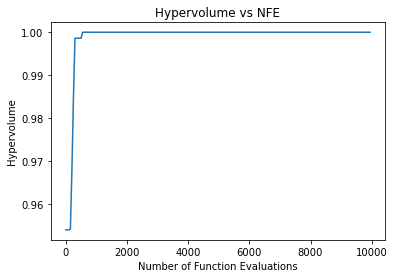

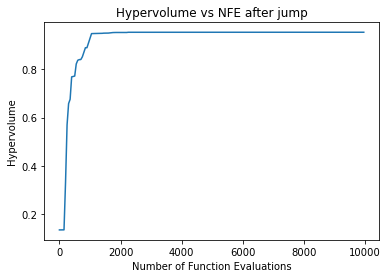

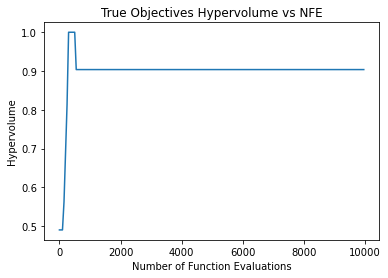

In [8]:
#### Plotting
nfe_array_fullrun = [hv_array[0] for hv_array in hypervol_full_dict]
hv_array_fullrun = [hv_array[1] for hv_array in hypervol_full_dict]
nfe_array_afterjump = [hv_array[0] for hv_array in hypervol_afterjump_dict]
hv_array_afterjump = [hv_array[1] for hv_array in hypervol_afterjump_dict]
nfe_array_true_fullrun = [hv_array[0] for hv_array in hypervol_true_full_dict]
hv_array_true_fullrun = [hv_array[1] for hv_array in hypervol_true_full_dict]

#### Plot hypervolume vs NFE
fig1 = plt.figure(1)
plt.plot(nfe_array_fullrun,hv_array_fullrun)
plt.xlabel('Number of Function Evaluations')
plt.ylabel('Hypervolume')
plt.title('Hypervolume vs NFE')
plt.show()
#fig1.savefig('HV_plot_eps_truss_' + str(run_number) + '.png')

#### Plot hypervolume vs NFE after hypervolume jump
fig2 = plt.figure(1)
plt.plot(nfe_array_afterjump,hv_array_afterjump)
plt.xlabel('Number of Function Evaluations')
plt.ylabel('Hypervolume')
plt.title('Hypervolume vs NFE after jump')
plt.show()
#fig2.savefig('HV_plot_post_jump_eps_truss_' + str(run_number) + '.png')

#### Plot true objectves hypervolume vs NFE
fig3 = plt.figure(1)
plt.plot(nfe_array_true_fullrun,hv_array_true_fullrun)
plt.xlabel('Number of Function Evaluations')
plt.ylabel('Hypervolume')
plt.title('True Objectives Hypervolume vs NFE')
plt.show()
#fig3.savefig('HV_plot_eps_truss_' + str(run_number) + '.png')